In [1]:
import pickle
import numpy as np
import pandas as pd 
from scipy.optimize import curve_fit, minimize 
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import matplotlib as mpl 

In [2]:
# spec some data 
dataDir = '../data/abs-08/'

# spec ahn "heuristic point" : temp, rate...
heuristicOpPoint = np.array([265, 15])

# get them data

with open(dataDir + 'cleaned.pkl', 'rb') as file:
    data = pickle.load(file)
    
df = data['df']
loadScaling = data['load_scaling']
dataTitle = data['title']

# sort... first by requested rates (small first) then by time 
df = df.sort_values(by=['requestedRate', 'time'])

print('load_scaling', loadScaling)
print('title', dataTitle)
df.describe()

load_scaling 606974
title ABS-08


temp         load         rate  requestedRate           time
count  3081.000000  3081.000000  3081.000000    3081.000000    3081.000000
mean    209.719952     0.354128    12.122421      11.370334   58515.009088
std      34.005014     0.223672     7.912161       7.414194   29591.443350
min     148.240463     0.070308     1.857637       2.000000    6811.000000
25%     182.780991     0.163712     5.225322       5.000000   33830.000000
50%     205.450638     0.302545    10.764093      10.000000   58205.000000
75%     236.052399     0.507109    16.331825      15.000000   81397.000000
max     279.994904     1.000000    27.345077      25.000000  123682.000000

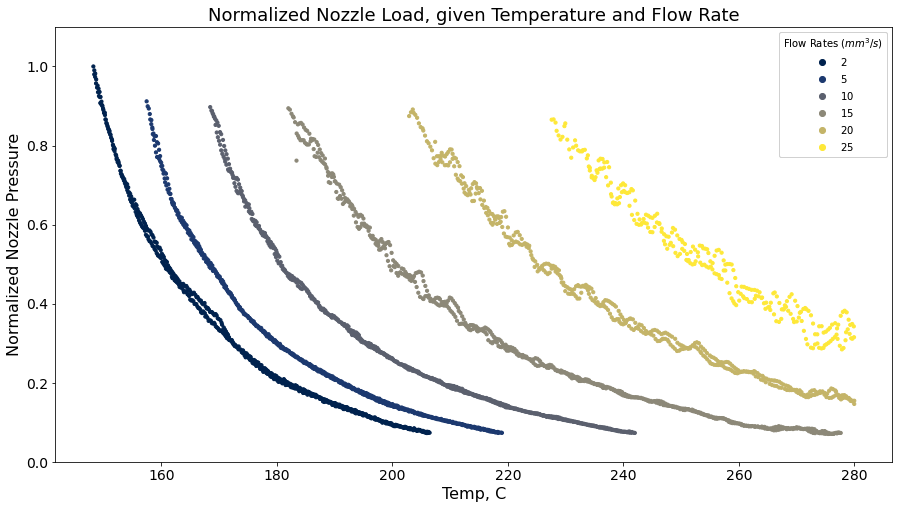

In [3]:
def plotPressureTemp(data):
    # setup to plot 
    plt.rcParams["figure.figsize"] = (12, 4)
    fig, ax = plt.subplots(figsize=(15, 8))
    
    plt.title('Normalized Nozzle Load, given Temperature and Flow Rate', fontsize=18)
    plt.xlabel('Temp, C', fontsize=16)
    plt.ylabel('Normalized Nozzle Pressure', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    ax.set_ylim(0, 1.1)
    
    scatter = plt.scatter(data['temp'], data['load'], c=data['requestedRate'], cmap='cividis', s=10)

    legend1 = plt.legend(*scatter.legend_elements(), title='Flow Rates ($mm^3/s$)')
    plt.gca().add_artist(legend1)
    
    plt.show()

plotPressureTemp(df)
# plotTemps(rawData)

   rate         a           b
0   2.0  0.954545 -146.712316
0   5.0  0.957962 -152.784659
0  10.0  0.964294 -163.201569
0  15.0  0.971663 -177.582888
0  20.0  0.976788 -197.415149
0  25.0  0.980154 -220.031229


C:\Users\jaker\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


array([<Axes: xlabel='rate'>, <Axes: xlabel='rate'>], dtype=object)

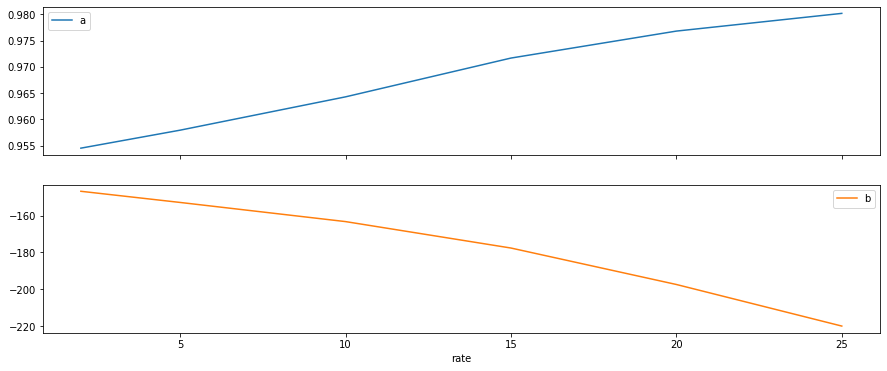

In [4]:
# let's try fits... per requestedRate value, 

def singleFlowFunc(t, a, b):
    return a ** (t + b)

rateSet = df['requestedRate'].unique()

singleFits = pd.DataFrame(columns = ['rate', 'a', 'b'])

for rate in rateSet:
    subset = df.loc[df['requestedRate'] == rate]
    popt, pcov = curve_fit(singleFlowFunc, subset.temp, subset.load)
    singleFits = pd.concat([singleFits, pd.DataFrame({
        'rate': [rate],
        'a': [popt[0]],
        'b': [popt[1]]
    })])
#     poptSet.append(popt)
#     print(rate, popt)

print(singleFits)

singleFits.plot(x='rate', subplots=True, figsize=(15, 6))

   rate         a           b
0   2.0  0.954545 -146.712316
0   5.0  0.957962 -152.784659
0  10.0  0.964294 -163.201569
0  15.0  0.971663 -177.582888
0  20.0  0.976788 -197.415149
0  25.0  0.980154 -220.031229


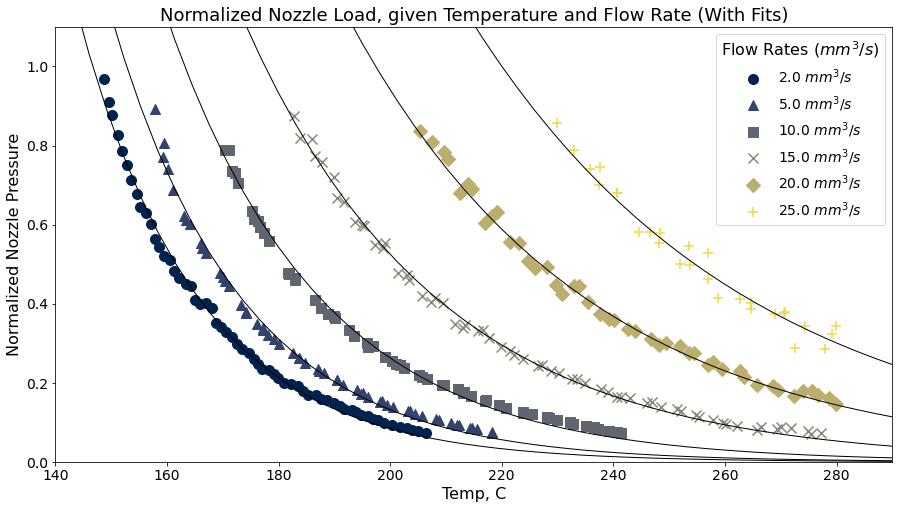

In [5]:
def plotSingleFits(data, fits, func):
    # let's mark some bounds, 
    xmin = round((data['temp'].min() - 10) / 10) * 10
    xmax = round((data['temp'].max() + 10) / 10) * 10 
    
    # setup to plot 
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.title('Normalized Nozzle Load, given Temperature and Flow Rate (With Fits)', fontsize=18)
    plt.xlabel('Temp, C', fontsize=16)
    plt.ylabel('Normalized Nozzle Pressure', fontsize=16)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(xmin, xmax)
    
    # markers and colors for colorblind / etc 
    markers = ['o', '^', 's', 'x', 'D', '+', '*', '<', '>', 'p', 'H']
    
    # get the colors from 'cividis' colorblind-safe map 
    cividis = mpl.colormaps['cividis']
    
    # set of rates to map colors / symbols 
    rateSet = data['requestedRate'].unique()
    
    for i, rate in enumerate(rateSet):
        subset = data[data['requestedRate'] == rate]
        # to render a few less, uncomment the next line 
        subset = subset.iloc[[i for i, _ in enumerate(subset.index) if i % 10 == 0]]
        plt.scatter(subset['temp'], subset['load'], 
                    s=100,
                    marker=markers[i],
                    # we can use a map's "colors" element, which is a list of colors 
                    # w/ len 256... then sample at some step through that; 
                    color=cividis.colors[i * 48],
                    label=f'{rate} $mm^3/s$')

    legend1 = plt.legend(title='Flow Rates ($mm^3/s$)', title_fontsize=16, fontsize=14)

    # one per rate / fit, 
    xpts = np.linspace(xmin, xmax, 50)
    rateSet = data['requestedRate'].unique()    
    for rate in rateSet:
        fit = fits.loc[fits['rate'] == rate]
        ypts = func(xpts, fit['a'][0], fit['b'][0])
        plt.plot(xpts, ypts, color='black', linewidth='1')
        
    plt.show()
    
print(singleFits)
plotSingleFits(df, singleFits, singleFlowFunc)

[ 0.96381256 81.35070547]
[-1.15501426e-01 -1.49741891e+02]


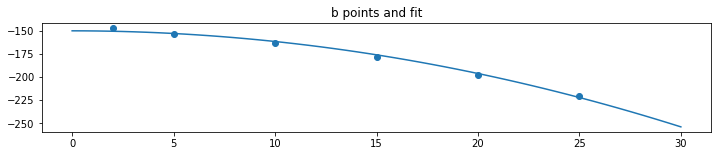

In [6]:
# and let's get a linear fit of all a's, 

def linFunc(x, a, b):
    return a * x + b

def expFunc(x, a, b):
    return - a ** (x + b) + 1

def quadFunc(x, a, b):
    return a * x ** 2 + b

popt_a_lin, pcov = curve_fit(linFunc, rateSet, singleFits['a'])
popt_a_exp, pcov = curve_fit(expFunc, rateSet, singleFits['a'])

popt_b_lin, pcov = curve_fit(linFunc, rateSet, singleFits['b'])
popt_b_quad, pcov = curve_fit(quadFunc, rateSet, singleFits['b'])
print(popt_a_exp)
print(popt_b_quad)

xpts = np.linspace(0, 30)

# apts = linFunc(xpts, popt_a_lin[0], popt_a_lin[1])
apts = expFunc(xpts, popt_a_exp[0], popt_a_exp[1])

# ypts = linFunc(xpts, popt_b_lin[0], popt_b_lin[1])
# ypts = expFunc(xpts, popt_b_exp[0] * -1, popt_b_exp[1])
# ypts = -ypts
bpts = quadFunc(xpts, popt_b_quad[0], popt_b_quad[1])

plt.rcParams["figure.figsize"] = (12, 2)

plt.plot(xpts, apts)
plt.title('a points and fit')
plt.scatter(singleFits['rate'], singleFits['a'])
plt.show()

plt.plot(xpts, bpts)
plt.title('b points and fit')
plt.scatter(singleFits['rate'], singleFits['b'])
plt.show()

In [7]:
# we want to combine those fits into the global P = f(T, Q)
# and refine the variables with global view... 

def quadParamFunc(tq, c, d, e, f):
    t, q = tq 
    # a = expFunc(q, popt_a_exp[0], popt_a_exp[1])
    # b = quadFunc(q, popt_b_quad[0], popt_b_quad[1])
    a = expFunc(q, c, d)
    b = quadFunc(q, e, f)
    return a ** (t + b)

# uses a minimizer to find flow given temp, pressure 
def quadParamInverse(tp, c, d, e, f):
    t, p = tp 
    # func that returns error (dist from target pres.) given guess (flow)
    def optFunc(q):
        guess = quadParamFunc((t, q), c, d, e, f)
        error = np.abs(p - guess)
        return error 
    
    flowGuess = minimize(optFunc, [1], method='Nelder-Mead')
    return flowGuess

# returns pressure given temp, flow:
def threeParamFunc(tq, c, d, e):
    t, q = tq 
    b = quadFunc(q, d, e) 
    return c ** (t + b)

# returns flow given temp, pressure
def threeParamInverse(tp, c, d, e):
    t, p = tp 
    return np.sqrt(np.log(p*np.exp(-(t + e)*np.log(c)))/(d*np.log(c)))

popt_start = np.array([popt_a_exp[0], popt_a_exp[1], popt_b_quad[0], popt_b_quad[1]])
popt_quad, pcov = curve_fit(quadParamFunc, (df['temp'], df['requestedRate']), df['load'], p0 = popt_start)
# popt_trip, pcov = curve_fit(threeParamFunc, (df['temp'], df['requestedRate']), df['load'], p0 = [0.95, -0.1, -100])

np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
print('fine tuning... ')
print('p_start \t', popt_start)
print('p_refined_quad \t', popt_quad)
# print('p_trip \t\t', popt_trip)

print('guessing...')
print(quadParamInverse((350, 0.5), *popt_quad))

fine tuning... 
p_start 	 [   0.9638   81.3507   -0.1155 -149.7419]
p_refined_quad 	 [   0.9623   79.1160   -0.1185 -147.5483]
guessing...
 final_simplex: (array([[35.1999],
       [35.1998]]), array([0.0000, 0.0000]))
           fun: 7.421507360882984e-07
       message: 'Optimization terminated successfully.'
          nfev: 54
           nit: 27
        status: 0
       success: True
             x: array([35.1999])


In [8]:
# to plot in 3-d:

def theBigPlot(data, fitFunc, inverseFunc, popt_sel, t_rel = 0, p_rel = 0):
    
    # min / max 
    xmin = round((data['temp'].min() - 50) / 10) * 10
    xmax = round((data['temp'].max() + 50) / 10) * 10 
    ymin = max(0, round((data['requestedRate'].min() - 10) / 10) * 10)
    ymax = round((data['requestedRate'].max() + 10) / 10) * 10
    print('xmin: {}, xmax: {}, ymin: {}, ymax: {}'.format(xmin, xmax, ymin, ymax))
    print('c = {:.3f}, d = {:.3f}, e = {:.3f}, f = {:.3f}'.format(*popt_sel))

    # grids 
    xgrid, ygrid = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 200))
    
    # func z
    zgrid = fitFunc((xgrid, ygrid), *popt_sel)
    zgrid = np.clip(zgrid, 0, 1.1)
        
    # for a selected presure, map flows... 
    xpts = np.linspace(xmin, xmax, 100)
    ypts = np.linspace(xmin, xmax, 100)
    for x in range(len(xpts)):
        guess = inverseFunc((xpts[x], p_rel), *popt_sel)
        if(guess.fun > 0.0001):
            ypts[x] = 0 
        else:
            # print(guess.x, ypts[x])
            ypts[x] = guess.x
    
    # do this a second time, to find the first-flow at p_sel = 1.0 
    for x in range(len(xpts)):
        guess = inverseFunc((xpts[x], 1.0), *popt_sel);
        # print(guess.x, guess.fun)
        if guess.fun > 0.0 and guess.fun < 0.0001:
            zeroFlowTemp = xpts[x]
            break
    
    # zero flow temp is where our t_rel is based, 
    # this is the temp where, at max pressure, flow first starts 
    print('zero flow = {:.2f}'.format(zeroFlowTemp))
        
    # do the plotting 
    plt.rcParams["figure.figsize"] = (15, 8)
        
    # plot the contour 
    plt.contourf(xgrid, ygrid, zgrid, cmap="cividis")
    cbar = plt.colorbar()
    cbar.set_label('Pressures, Normalized $0-1$', fontsize=16)
    cbar.ax.tick_params(labelsize=12)

    # and the line, 
    plt.plot(xpts, ypts, color='black')
    
    # now let's calc and plot an extracted point... 
    if t_rel > 0 and p_rel > 0:
        t_sel = zeroFlowTemp + t_rel
        q_sel = inverseFunc((t_sel, p_rel), *popt_sel).x 
        plt.scatter(zeroFlowTemp, 0, marker='o', color='black', s=150)
        plt.scatter(t_sel, q_sel, marker='d', color='black', s=150)

    plt.title('Map of Nozzle Pressures given Temp and Flowrate for ' + dataTitle, fontsize=18)
    plt.xlabel('Nozzle Setpoint $(^{\circ}C)$', fontsize=16)
    plt.ylabel('Polymer Flowrate $(mm^3/s)$', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    return zeroFlowTemp
    
    
# theBigPlot(df, threeParamFunc, threeParamInverse, popt_trip)
zeroFlowTemp = theBigPlot(df, quadParamFunc, quadParamInverse, popt_quad, 100, 0.5)

# get a pressure for... 
def reportEquivalentPrel(temp, flow):
    rel_p_given_temp_pres = quadParamFunc((temp, flow), *popt_quad)
    print('for ' + dataTitle + ' temp: {}, flow: {} , pressure maps to {:2f}'.format(temp, flow, rel_p_given_temp_pres))

# reportEquivalentPrel(220, 18.0)
# reportEquivalentPrel(220, 12.6)
# reportEquivalentPrel(220, 9.0)

xmin: 100, xmax: 330, ymin: 0, ymax: 40
c = 0.962, d = 79.116, e = -0.118, f = -147.548
zero flow = 148.79


In [9]:
def getRealParams(t_rel, p_rel, track_height, track_width):
    t_actual = zeroFlowTemp + t_rel 
    q_actual = quadParamInverse((t_actual, p_rel), *popt_quad).x[0]
    # flow to rate 
    lin_rate = q_actual / (track_height * track_width)
    print('for t_rel: {:.2f}, p_rel: {:.2f}, use t: {:.2f}, q: {:.2f} ... {:.1f}'.format(t_rel, p_rel, t_actual, q_actual, lin_rate))
#     print('for t_rel: {:.2f}, p_rel: {:.2f}, use \t: {:.2f}, q: {:.2f}'.format(t_rel, p_rel, t_actual, q_actual))
    
getRealParams(80, 0.75, 0.2, 0.45)
getRealParams(80, 0.25, 0.2, 0.45)
getRealParams(80, 0.10, 0.2, 0.45)
getRealParams(80, 0.05, 0.2, 0.45)

# getRealParams(80, 0.75, 0.4, 0.9)
# getRealParams(80, 0.25, 0.4, 0.9)
# getRealParams(80, 0.10, 0.4, 0.9)
# getRealParams(80, 0.05, 0.4, 0.9)

for t_rel: 80.00, p_rel: 0.75, use t: 228.79, q: 23.68 ... 263.1
for t_rel: 80.00, p_rel: 0.25, use t: 228.79, q: 15.66 ... 174.0
for t_rel: 80.00, p_rel: 0.10, use t: 228.79, q: 9.98 ... 110.9
for t_rel: 80.00, p_rel: 0.05, use t: 228.79, q: 5.93 ... 65.9
